#Feature extraction from sequences

In [ ]:
import h5py
import torch
import numpy as np
import pandas as pd

# === Constants ===
SAMPLE_RATE = 100.0  # 1 / 0.01s = 100Hz
DURATION = 90.0      # 90 seconds
EXPECTED_SAMPLES = int(SAMPLE_RATE * DURATION)  # Should be 9000

# === ROCOF Calculation (Updated fs) ===
def compute_max_rocof(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    N = len(signal)
    fft_signal = torch.fft.fft(signal)
    analytic_fft = torch.cat([
        fft_signal[0:1],
        2 * fft_signal[1:N//2],
        fft_signal[N//2:N//2+1],
        torch.zeros(N - N//2 - 1, device=signal.device)
    ])
    analytic_signal = torch.fft.ifft(analytic_fft)
    phase = torch.angle(analytic_signal)
    instantaneous_freq = torch.diff(phase) * (sample_rate / (2 * torch.pi))
    rocof = torch.diff(instantaneous_freq) * sample_rate
    return torch.max(torch.abs(rocof)).item()

# === Time of Nadir (Updated fs) ===
def find_nadir_time(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    nadir_idx = torch.argmin(signal).item()
    return nadir_idx / sample_rate  # Time in seconds

# === Load Data ===
with h5py.File('simulink_dataset_different_disturbances_2x{hydro+steam}_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]        # shape: (3, 9000, N) [Verify!]
    all_targets = f['all_targets'][:]  # shape: (2, N)

# # === Verify Signal Length ===
# if all_data.shape[1] != EXPECTED_SAMPLES:
#     print(f"⚠️ Warning: Expected {EXPECTED_SAMPLES} samples, got {all_data.shape[1]}. Adjust SAMPLE_RATE or DURATION.")

# === Transpose Data ===
X = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 9000, 3)
Y = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 2)

# === Feature Extraction (Now uses SAMPLE_RATE) ===
def extract_features(signal, sample_rate=SAMPLE_RATE):
    return {
        'mean': signal.mean().item(),
        'std': signal.std().item(),
        'max': signal.max().item(),
        'min': signal.min().item(),
        'ptp': (signal.max() - signal.min()).item(),
        'rms': torch.sqrt(torch.mean(signal**2)).item(),
        'max_rocof': compute_max_rocof(signal, sample_rate),
        'nadir_time': find_nadir_time(signal, sample_rate)
    }

# === RMS Ratio (Unchanged) ===
def compute_rms_ratio(signal, early_pct=0.3, late_pct=0.1):
    T = signal.shape[0]
    early_len = int(T * early_pct)
    late_len = int(T * late_pct)
    early_rms = torch.sqrt(torch.mean(signal[:early_len] ** 2)).item()
    late_rms = torch.sqrt(torch.mean(signal[-late_len:] ** 2)).item()
    return late_rms / (early_rms + 1e-8)

# === Process All Samples ===
rows = []
for i in range(X.shape[0]):
    feats = {}
    for j, name in enumerate(['f1', 'f2', 'ptie']):
        sig = X[i, :, j]
        sig_feats = extract_features(sig, SAMPLE_RATE)
        for stat, val in sig_feats.items():
            feats[f"{name}_{stat}"] = val
        feats[f"{name}_rms_ratio"] = compute_rms_ratio(sig)
    feats['H1'] = Y[i, 0].item()
    feats['H2'] = Y[i, 1].item()
    rows.append(feats)

# === Save CSV ===
df = pd.DataFrame(rows)
df.to_csv("simulink_features_2x{hydro_power+steam}_sources.csv", index=False)
print(f"✅ Saved features for {SAMPLE_RATE}Hz sampling to 'simulink_features_2x[hydro_power+steam]_sources.csv'")

✅ Saved features for 100.0Hz sampling to 'simulink_features_2x[hydro_power+steam]_sources.csv'


In [ ]:
import h5py
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# === Load the dataset ===
with h5py.File('simulink_dataset_different_disturbances_2x{hydro+steam}_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]        # shape: (3, 6001, N)
    all_targets = f['all_targets'][:]  # shape: (2, N)

In [ ]:
print(all_data.shape)
print(all_targets.shape)

(3, 9001, 1000)
(2, 1000)


In [ ]:
import matplotlib.pyplot as plt

def plot_sample(idx, X, Y, title_suffix=""):
    Δf1 = X[idx, :, 0].numpy()
    Δf2 = X[idx, :, 1].numpy()
    ΔPtie = X[idx, :, 2].numpy()
    H1, H2 = Y[idx, 0].item(), Y[idx, 1].item()

    plt.figure(figsize=(14, 4))
    plt.plot(Δf1, label="Δf1")
    plt.plot(Δf2, label="Δf2")
    plt.plot(ΔPtie, label="ΔPtie")
    plt.title(f"Sample #{idx} — H1: {H1:.2f}, H2: {H2:.2f} {title_suffix}")
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Convert and transpose
X_old = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
Y_old = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 2)

print(X_old.shape)
print(Y_old.shape)

torch.Size([1000, 9001, 3])
torch.Size([1000, 2])


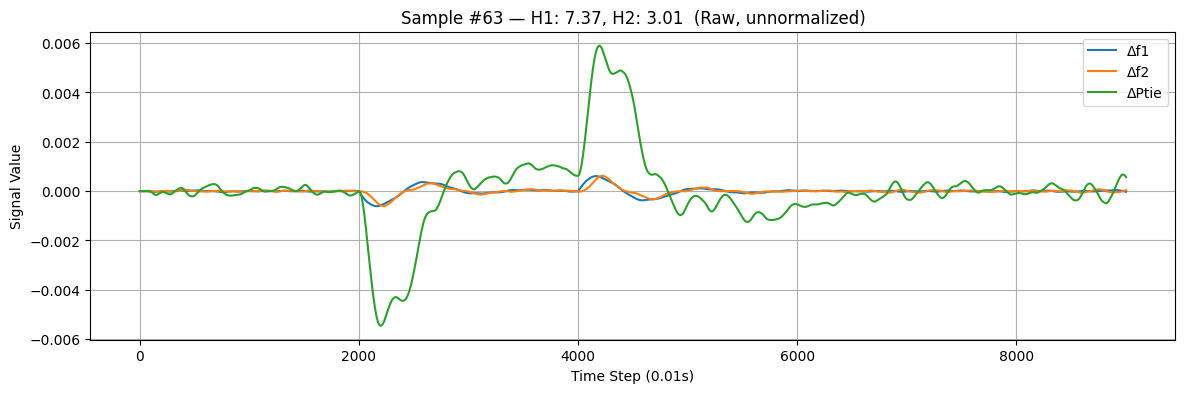

In [ ]:
plot_sample(idx=63, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

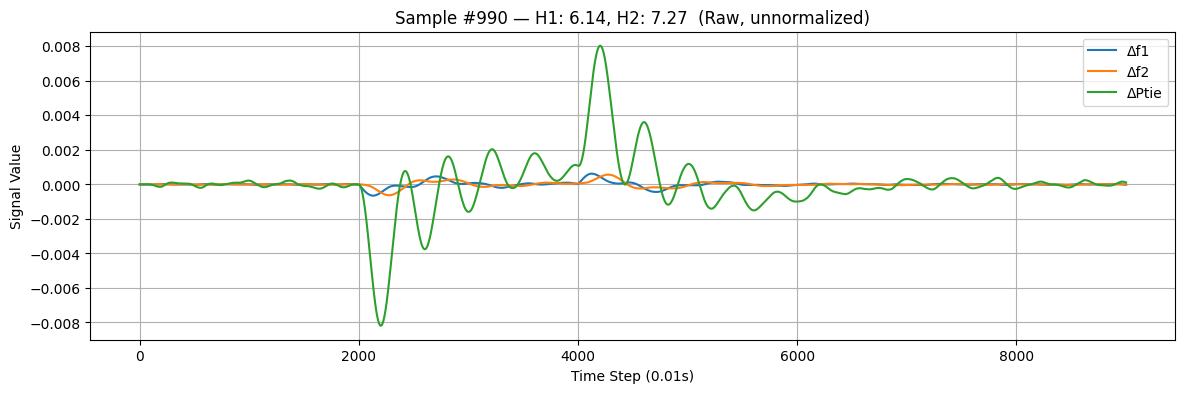

In [ ]:
plot_sample(idx=990, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

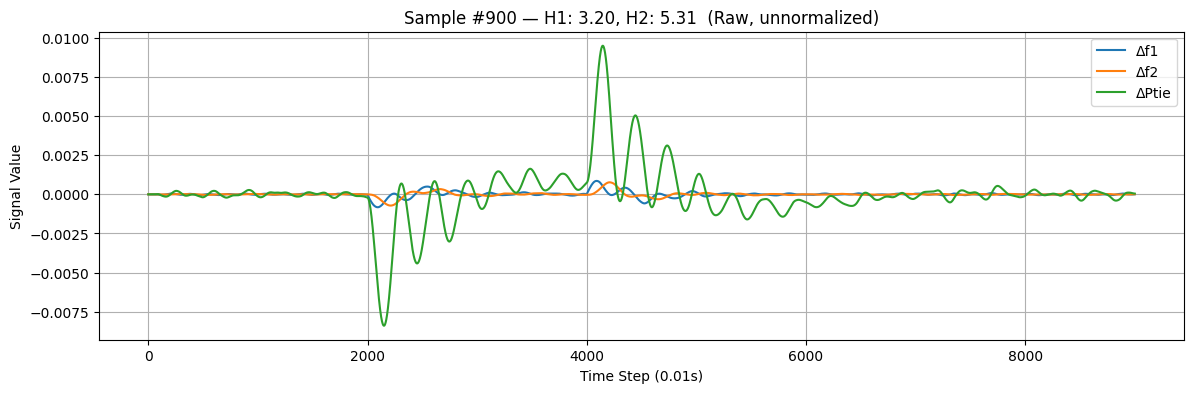

In [ ]:
plot_sample(idx=900, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

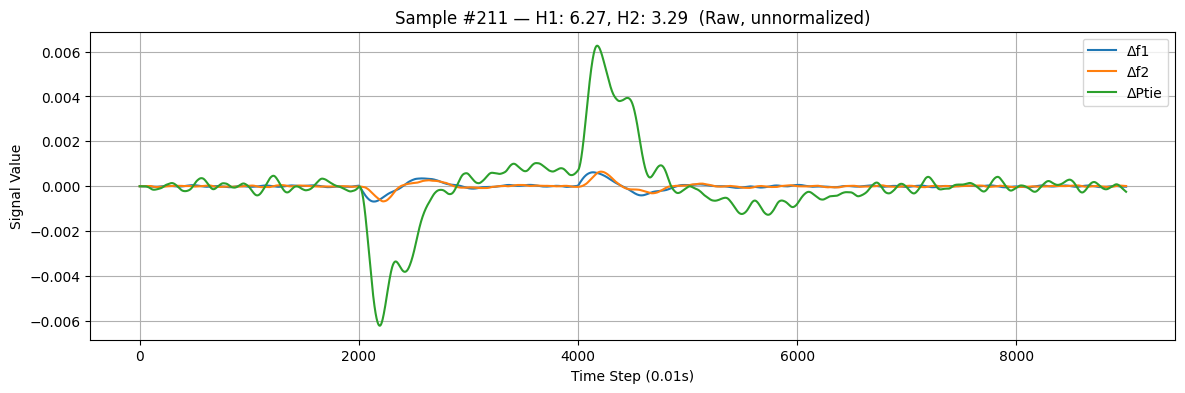

In [ ]:
plot_sample(idx=211, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

New code


In [ ]:
# # Suppose you’ve already loaded X, Y as in your script:
# # X has shape (N, 6001, 5), Y has shape (N, 2)



# # You can also add a suffix, e.g.:
# plot_sample(42, X, Y, title_suffix="(Disturbance demo)")


In [1]:
import pandas as pd

Statistic_Data = pd.read_csv('simulink_features_2x{hydro_power+steam}_sources.csv')

Statistic_Data.head()

,f1_mean,f1_std,f1_max,f1_min,f1_ptp,f1_rms,f1_max_rocof,f1_nadir_time,f1_rms_ratio,f2_mean,...,ptie_std,ptie_max,ptie_min,ptie_ptp,ptie_rms,ptie_max_rocof,ptie_nadir_time,ptie_rms_ratio,H1,H2
0,3.801883e-07,0.000161,0.000793,-0.000911,0.001704,0.000161,10388.629883,20.96,0.213403,4.002504e-07,...,0.001646,0.008292,-0.008191,0.016483,0.001646,10173.201172,21.50,0.149828,3.169067,4.289126
1,9.449165e-09,0.000159,0.000618,-0.000562,0.001180,0.000159,10018.506836,21.55,0.096809,1.171110e-07,...,0.001773,0.008473,-0.007533,0.016005,0.001773,10040.671875,22.22,0.062797,7.892919,7.670897
2,-1.357468e-07,0.000146,0.000542,-0.000583,0.001125,0.000146,10059.112305,21.42,0.120236,-9.834293e-08,...,0.001569,0.007071,-0.006761,0.013832,0.001569,10086.951172,22.06,0.098594,7.598004,5.541729
3,1.613082e-07,0.000152,0.000605,-0.000587,0.001192,0.000152,10411.549805,21.42,0.075255,3.336337e-07,...,0.001747,0.008376,-0.007849,0.016225,0.001747,10002.264648,22.13,0.057950,7.207389,7.465922
4,6.028074e-08,0.000155,0.000570,-0.000604,0.001174,0.000155,10027.429688,21.47,0.081594,-1.476075e-07,...,0.001533,0.005963,-0.005758,0.011721,0.001533,10004.240234,21.85,0.106225,7.267733,3.340430


In [2]:
Statistic_Data.tail()

,f1_mean,f1_std,f1_max,f1_min,f1_ptp,f1_rms,f1_max_rocof,f1_nadir_time,f1_rms_ratio,f2_mean,...,ptie_std,ptie_max,ptie_min,ptie_ptp,ptie_rms,ptie_max_rocof,ptie_nadir_time,ptie_rms_ratio,H1,H2
995,4.627318e-08,0.000152,0.000776,-0.000746,0.001522,0.000152,10020.432617,21.01,0.123888,2.057263e-08,...,0.001660,0.008428,-0.007825,0.016253,0.001660,10005.624023,21.62,0.124211,4.195250,4.548054
996,-4.184107e-08,0.000150,0.000702,-0.000681,0.001384,0.000150,10066.075195,21.17,0.100350,-1.412198e-07,...,0.001551,0.007553,-0.006824,0.014377,0.001551,10001.739258,21.72,0.065183,5.205702,3.975487
997,2.195707e-07,0.000161,0.000730,-0.000697,0.001427,0.000161,10014.919922,21.04,0.121529,2.481683e-07,...,0.001838,0.009362,-0.008334,0.017696,0.001838,10022.103516,21.78,0.059672,4.778116,7.864991
998,5.312219e-08,0.000150,0.000585,-0.000628,0.001213,0.000150,10194.275391,21.22,0.098681,1.008520e-07,...,0.001659,0.007682,-0.007552,0.015234,0.001659,11243.133789,21.95,0.056007,6.525545,6.214193
999,9.346093e-08,0.000152,0.000712,-0.000681,0.001393,0.000152,10042.947266,21.21,0.102010,2.367795e-07,...,0.001726,0.008773,-0.007954,0.016728,0.001726,10003.666016,21.86,0.096350,5.418651,6.016595


Because the calculation of Rocof values is wrong we drop the from our dataset


In [3]:
import pandas as pd
df = pd.read_csv("simulink_features_2x{hydro_power+steam}_sources.csv")
rocof_cols = [c for c in df.columns if c.endswith("_max_rocof")]
df_clean = df.drop(columns=rocof_cols)  # προτείνεται να πετάξεις και το ptie_max_rocof αν υπάρχει
df_clean.to_csv("simulink_features_2x{hydro_power+steam}_sources_FINAL.csv", index=False)
print("Έτοιμο: simulink_features_2x{hydro_power+steam}_sources_FINAL.csv")


Έτοιμο: simulink_features_2x{hydro_power+steam}_sources_FINAL.csv


In [4]:
df = df_clean.copy()

In [5]:
df.shape

(1000, 26)

##PREPROCESS

CHECKING FOR INSTABILITY INPUT SEQUENCES

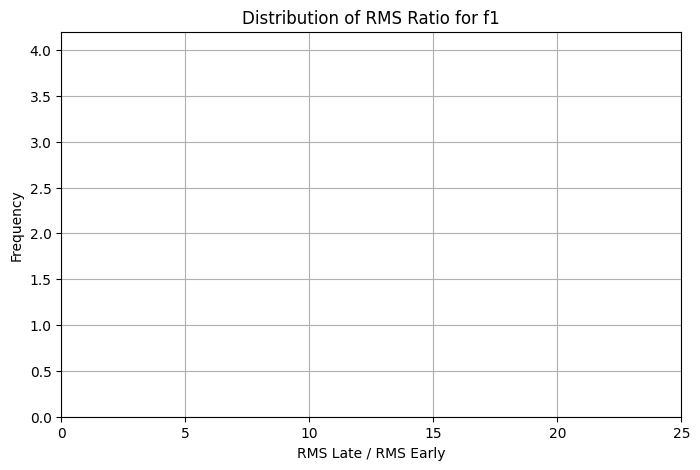

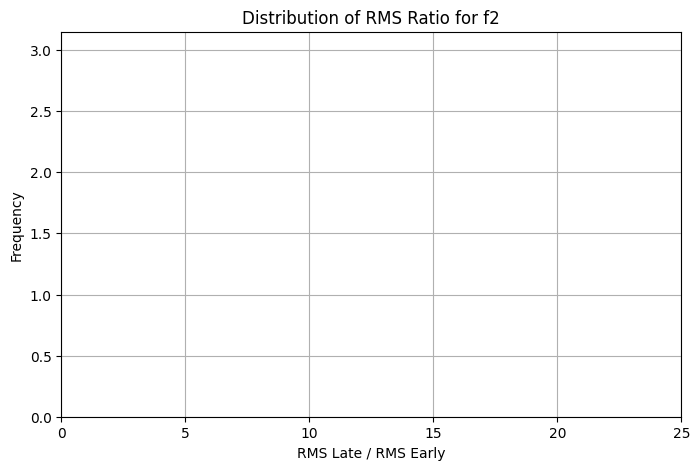

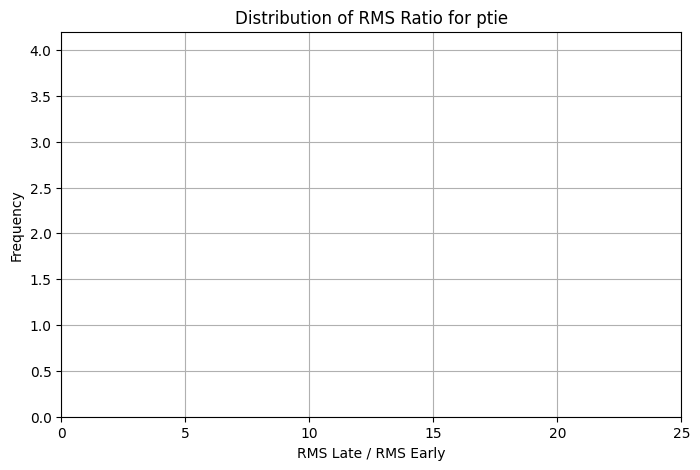

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.read_csv('simulink_feature_dataset_1000_outliers.csv')

for channel in ['f1', 'f2', 'ptie']:
    plt.figure(figsize=(8, 5))
    plt.hist(df[f'{channel}_rms_ratio'], bins=10000)
    plt.title(f'Distribution of RMS Ratio for {channel}')
    plt.xlabel('RMS Late / RMS Early')
    plt.ylabel('Frequency')
    plt.xlim(0, 25)  # Adjust as needed
    plt.grid(True)
    plt.show()


In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data and features
with h5py.File('simulink_dataset_different_disturbances_2x{hydro+steam}_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]  # (3, 6001, N)

X = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
df = pd.read_csv('simulink_features_2x{hydro_power+steam}_sources.csv')

# Select samples with high RMS ratio for any channel
threshold = 2
high_ratio_idx = df[
    (df['f1_rms_ratio'] > threshold) |
    (df['f2_rms_ratio'] > threshold) |
    (df['ptie_rms_ratio'] > threshold)
].index

print(f"Found {len(high_ratio_idx)} sequences with RMS ratio > {threshold}")

# Plot a few high-ratio sequences with H1 and H2 in the title
for idx in high_ratio_idx[:3]:  # Plot first 3
    h1_val = df.loc[idx, 'H1']
    h2_val = df.loc[idx, 'H2']

    plt.figure(figsize=(12, 5))
    for j, name in enumerate(['Δf1', 'Δf2', 'ΔPtie']):
        plt.plot(X[idx, :, j], label=name)
    plt.title(f"Sample #{idx} — H1: {h1_val:.2f}, H2: {h2_val:.2f} (RMS ratio > {threshold})")
    plt.xlabel("Time Step")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.show()


Found 0 sequences with RMS ratio > 2


In [7]:
import pandas as pd

#df = pd.read_csv('simulink_feature_dataset_1000_outliers.csv')

threshold = 2
unstable_counts = {
    channel: (df[f'{channel}_rms_ratio'] > threshold).sum()
    for channel in ['f1', 'f2', 'ptie']
}

total_unstable = (df[['f1_rms_ratio', 'f2_rms_ratio', 'ptie_rms_ratio']] > threshold).any(axis=1).sum()

print(f"Number of unstable sequences with RMS ratio > {threshold}:")
for ch, count in unstable_counts.items():
    print(f"  {ch}: {count}")

print(f"Total (any channel): {total_unstable}")


Number of unstable sequences with RMS ratio > 2:
  f1: 0
  f2: 0
  ptie: 0
Total (any channel): 0


In [8]:
# Assuming df is your existing DataFrame
df = df[
    (df['f1_rms_ratio'] <= 2) &
    (df['f2_rms_ratio'] <= 2) &
    (df['ptie_rms_ratio'] <= 2)
]

print(f"Filtered DataFrame shape: {df.shape}")


Filtered DataFrame shape: (1000, 26)


#CORRATION MATRIX

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def filter_features_by_correlation(df, target_columns=['H1', 'H2'], threshold=0.3,
                                 verbose=True, plot_corr=True, figsize=(12, 8)):
    """
    Filter features based on their absolute correlation with target columns.

    Parameters:
    - df: pandas DataFrame containing both features and targets
    - target_columns: list of target column names (default ['H1', 'H2'])
    - threshold: minimum absolute correlation to keep a feature (default 0.2)
    - verbose: whether to print the correlation results (default True)
    - plot_corr: whether to plot the correlation heatmap (default True)
    - figsize: size of the correlation plot (default (12, 8))

    Returns:
    - DataFrame containing only selected features and targets
    - List of selected feature names
    """
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()

    # Select only correlations of features with targets
    feature_corr = corr_matrix[target_columns].drop(index=target_columns)

    if verbose:
        print("🔍 Correlation of features with targets:\n")
        print(feature_corr)

    # Plot correlation heatmap
    if plot_corr:
        plt.figure(figsize=figsize)
        sns.heatmap(feature_corr, annot=True, cmap='coolwarm',
                   vmin=0, vmax=1, linewidths=0.5)
        plt.title(f"Absolute Correlation with Targets (Threshold = {threshold})")
        plt.show()

    # Keep features where correlation with any target is above threshold
    mask = (feature_corr > threshold).any(axis=1)
    selected_features = feature_corr[mask].index.tolist()

    if verbose:
        print(f"\n✅ Selected features (correlation > {threshold}):", selected_features)

    # Return filtered dataframe and selected features
    return df[selected_features + target_columns], selected_features

🔍 Correlation of features with targets:

                       H1        H2
f1_mean          0.025710  0.015480
f1_std           0.573291  0.191139
f1_max           0.933057  0.001070
f1_min           0.949340  0.034559
f1_ptp           0.958621  0.017938
f1_rms           0.573290  0.191139
f1_nadir_time    0.956617  0.126743
f1_rms_ratio     0.628445  0.056428
f2_mean          0.061879  0.054024
f2_std           0.200756  0.246451
f2_max           0.676387  0.579686
f2_min           0.675441  0.564229
f2_ptp           0.694356  0.588187
f2_rms           0.200762  0.246455
f2_nadir_time    0.697055  0.668844
f2_rms_ratio     0.010032  0.508229
ptie_mean        0.020487  0.004063
ptie_std         0.431211  0.858034
ptie_max         0.692701  0.678253
ptie_min         0.690474  0.699441
ptie_ptp         0.701056  0.698144
ptie_rms         0.431212  0.858033
ptie_nadir_time  0.928211  0.292787
ptie_rms_ratio   0.216582  0.241616


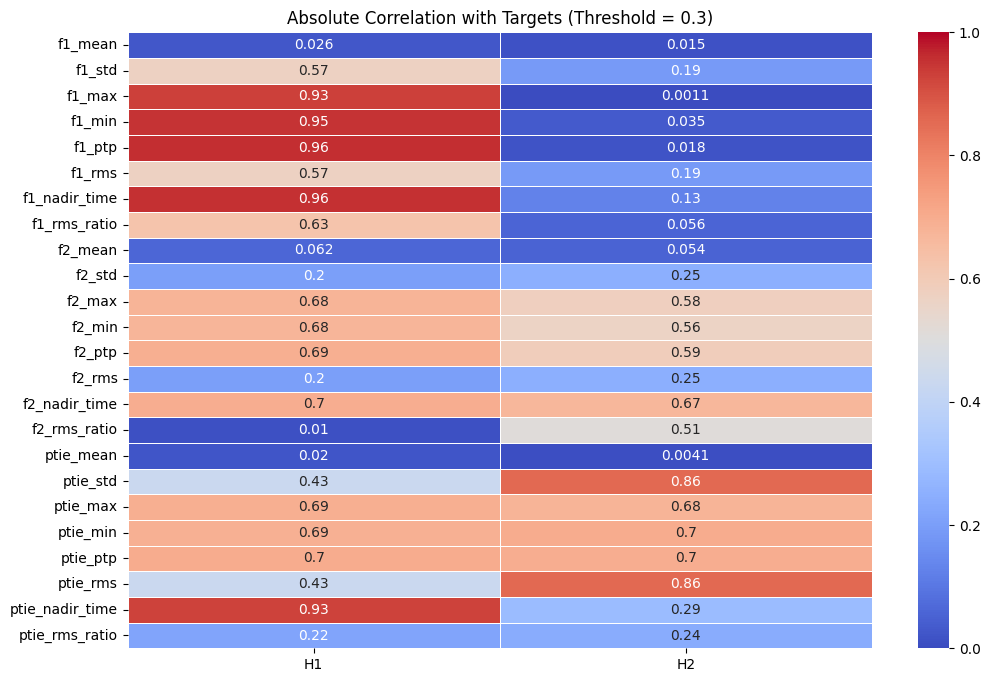


✅ Selected features (correlation > 0.3): ['f1_std', 'f1_max', 'f1_min', 'f1_ptp', 'f1_rms', 'f1_nadir_time', 'f1_rms_ratio', 'f2_max', 'f2_min', 'f2_ptp', 'f2_nadir_time', 'f2_rms_ratio', 'ptie_std', 'ptie_max', 'ptie_min', 'ptie_ptp', 'ptie_rms', 'ptie_nadir_time']


In [10]:
# With default visualization
df_filtered, selected_features = filter_features_by_correlation(df)




In [11]:
df_filtered.shape

(1000, 20)

In [12]:
# import pandas as pd
# import numpy as np

# # Set random seed for reproducibility
# np.random.seed(42)

# # Create the sampled DataFrames
# df2 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.25), replace=False))
# df3 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.50), replace=False))
# df4 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.75), replace=False))

# # Verify the sizes
# print(f"Original size: {len(df)} rows")
# print(f"df2 (25% dropped): {len(df2)} rows (should be ~541)")
# print(f"df3 (50% dropped): {len(df3)} rows (should be ~361)")
# print(f"df4 (75% dropped): {len(df4)} rows (should be ~180)")

#EVALUATION

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_predictions(Y_true, Y_pred, names=['H1', 'H2'], verbose=True):
    """
    Evaluate predictions using various metrics and print the results.

    Parameters:
    - Y_true: numpy array of true values
    - Y_pred: numpy array of predicted values
    - names: list of names for each output variable
    - verbose: whether to print the results (default True)

    Returns:
    - Dictionary containing all evaluation metrics for each output
    """
    results = {}

    for i, name in enumerate(names):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        metrics = {
            'R2': r2_score(true, pred),
            'MAE': mean_absolute_error(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred)),
            'MAPE': mean_absolute_percentage_error(true, pred)*100
        }

        results[name] = metrics

        if verbose:
            print(f"{name} → R²: {metrics['R2']:.5f}, RMSE: {metrics['RMSE']:.5f}, "
                  f"MAE: {metrics['MAE']:.5f}, MAPE: {metrics['MAPE']:.2f}%")




    return results

#COMPARASION DATAFRAME

In [14]:
def create_comparison_df(Y_true, Y_pred, names=['H1', 'H2']):
    """
    Create a DataFrame comparing actual and predicted values.

    Parameters:
    - Y_true: numpy array of true values
    - Y_pred: numpy array of predicted values
    - names: list of names for each output variable

    Returns:
    - Pandas DataFrame with actual and predicted values side by side
    """
    data = {}
    for i, name in enumerate(names):
        data[f'{name}_actual'] = Y_true[:, i]
        data[f'{name}_pred'] = Y_pred[:, i]

    return pd.DataFrame(data)

#PLOTTER OF ESTIMATIONS

In [15]:
def plot_predictions(Y_true, Y_pred, target_names=['H1', 'H2'],
                    figsize=(12, 5), alpha=0.6, color='b',
                    diagonal_line=True, grid=True, tight_layout=True):
    """
    Create actual vs. predicted scatter plots for multiple targets.

    Parameters:
    - Y_true: Array of true values (2D array with shape [n_samples, n_targets])
    - Y_pred: Array of predicted values (same shape as Y_true)
    - target_names: List of names for each target variable
    - figsize: Figure size (width, height)
    - alpha: Transparency of scatter points
    - color: Color of scatter points
    - diagonal_line: Whether to plot the ideal prediction line
    - grid: Whether to show grid lines
    - tight_layout: Whether to adjust subplot spacing

    Returns:
    - matplotlib figure object
    """
    n_targets = Y_true.shape[1]
    fig, axes = plt.subplots(1, n_targets, figsize=figsize)

    if n_targets == 1:
        axes = [axes]  # Ensure axes is iterable for single target case

    for i, ax in enumerate(axes):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        # Scatter plot
        ax.scatter(true, pred, alpha=alpha, color=color)

        # Calculate R² score
        r2 = r2_score(true, pred)

        # Plot ideal prediction line
        if diagonal_line:
            min_val = min(true.min(), pred.min())
            max_val = max(true.max(), pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--',
                   label='Ideal prediction')

        # Labels and title
        ax.set_xlabel(f"True {target_names[i]}")
        ax.set_ylabel(f"Predicted {target_names[i]}")
        ax.set_title(f"{target_names[i]} Prediction\n(R² = {r2:.3f})")

        if grid:
            ax.grid(True)

        if diagonal_line:
            ax.legend()

    if tight_layout:
        plt.tight_layout()

    return fig

#BOXPLOT

In [16]:
def plot_error_analysis(Y_true, Y_pred, target_names=['H1', 'H2'],
                       plot_type='boxplot', figsize=(10, 6),
                       show_stats=True, palette='Set2'):
    """
    Visualize prediction errors with multiple plot types and statistics.

    Parameters:
    - Y_true: Array of true values
    - Y_pred: Array of predicted values
    - target_names: List of target names
    - plot_type: 'boxplot', 'violin', or 'combined'
    - figsize: Figure dimensions
    - show_stats: Whether to print error statistics
    - palette: Color palette name

    Returns:
    - matplotlib figure object
    - dictionary of error statistics
    """
    # Calculate absolute errors for each target
    errors = np.abs(Y_pred - Y_true)
    stats = {}

    # Calculate error statistics
    for i, name in enumerate(target_names):
        stats[name] = {
            'mean_error': np.mean(errors[:, i]),
            'median_error': np.median(errors[:, i]),
            'max_error': np.max(errors[:, i]),
            'std_dev': np.std(errors[:, i])
        }

    if show_stats:
        print("📊 Error Statistics:")
        for name in target_names:
            print(f"\n{name}:")
            print(f"  Mean Absolute Error: {stats[name]['mean_error']:.4f}")
            print(f"  Median Absolute Error: {stats[name]['median_error']:.4f}")
            print(f"  Max Error: {stats[name]['max_error']:.4f}")
            print(f"  Standard Deviation: {stats[name]['std_dev']:.4f}")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot based on selected type
    if plot_type == 'boxplot':
        bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],
                       labels=[f'{name} Error' for name in target_names],
                       patch_artist=True)
        # Add colors
        colors = sns.color_palette(palette, len(target_names))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

    elif plot_type == 'violin':
        vp = ax.violinplot([errors[:, i] for i in range(len(target_names))],
                         showmedians=True)
        colors = sns.color_palette(palette, len(target_names))
        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        ax.set_xticks(np.arange(1, len(target_names)+1))
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    elif plot_type == 'combined':
        positions = np.arange(1, len(target_names)+1)
        # Violin plot
        vp = ax.violinplot([errors[:, i] for i in range(len(target_names))],
                         positions=positions-0.15,
                         widths=0.3,
                         showmedians=True)
        # Box plot
        bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],
                      positions=positions+0.15,
                      widths=0.2,
                      patch_artist=True)

        # Styling
        colors = sns.color_palette(palette, len(target_names))
        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_xticks(positions)
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    # Common formatting
    ax.set_ylabel('Absolute Error')
    ax.set_title('Prediction Error Analysis')
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig, stats

#CDF PLOTTER

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Dict, Optional

# This function plots the CDF of multiple datasets provided in a dictionary.
def plot_cdf(data_dict: dict, title: str = 'CDF Plot', xlabel: str = 'Values',
             ylabel: str = 'Cumulative Probability', figsize=(8, 6), grid=True) -> plt.Figure:
    """
    Plots the Cumulative Distribution Function (CDF) for multiple datasets.

    Parameters:
    - data_dict: Dictionary where keys are labels and values are arrays of data.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - figsize: Figure size.
    - grid: Whether to show grid.

    Returns:
    - matplotlib Figure object
    """
    fig, ax = plt.subplots(figsize=figsize)

    for label, data in data_dict.items():
        # Filter out NaN/inf just in case
        data = data[np.isfinite(data)]
        if len(data) == 0:
            print(f"Warning: No finite data for label '{label}'. Skipping.")
            continue

        sorted_data = np.sort(data)
        # Calculate CDF as the empirical CDF
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.plot(sorted_data, cdf, label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    if grid:
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig

# The plot_error_cdfs function remains the same, as it now calls the correctly
# structured plot_cdf function.
def plot_error_cdfs(Y_true: np.ndarray,
                   Y_pred: np.ndarray,
                   target_names: Optional[List[str]] = None,
                   **kwargs) -> plt.Figure:
    """
    Calculate absolute errors and plot their CDFs using the generic plot_cdf function.

    Parameters:
    - Y_true: Array of true values (shape [n_samples, n_targets])
    - Y_pred: Array of predicted values (same shape as Y_true)
    - target_names: Optional list of target names
    - **kwargs: Additional arguments for plot_cdf()

    Returns:
    - matplotlib Figure object
    """
    # Calculate absolute errors for each target
    errors = np.abs(Y_pred - Y_true)

    # Default target names
    if target_names is None:
        target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]
    elif len(target_names) != Y_true.shape[1]:
         print(f"Warning: target_names length ({len(target_names)}) does not match number of targets ({Y_true.shape[1]}). Using default names.")
         target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]


    # Create error dictionary for the generic plotter
    error_dict = {f'{name} Error': errors[:, i]
                 for i, name in enumerate(target_names)}

    # Plot using the generic CDF function
    # Pass the error_dict and any extra kwargs
    return plot_cdf(error_dict, xlabel='Absolute Error', title='CDF of Absolute Prediction Errors', **kwargs)

# Now you can use it like this (this part is unchanged):
# fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

#SPLITTING AND SCALING

In [18]:
X = df_filtered.iloc[:, :-2].values
Y = df_filtered.iloc[:, -2:].values

print(X.shape)
print(Y.shape)


(1000, 18)
(1000, 2)


In [19]:
# X = df2.iloc[:, :-2].values
# Y = df2.iloc[:, -2:].values

# print(X.shape)
# print(Y.shape)


In [20]:
from sklearn.model_selection import train_test_split

# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
Y_test.shape


(300, 2)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

#ESTIMATION MODELS






##RANDOM FOREST

In [23]:
# === Train random forest ===

from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train_scaled)

# === Predict and evaluate ===
Y_pred_scaled = rf.predict(X_test_scaled)


Y_pred = scaler.inverse_transform(Y_pred_scaled)
Y_true = scaler.inverse_transform(Y_test_scaled)

In [24]:
# Example usage:
results = evaluate_predictions(Y_true, Y_pred)

H1 → R²: 0.98337, RMSE: 0.19216, MAE: 0.15073, MAPE: 2.85%
H2 → R²: 0.98119, RMSE: 0.20070, MAE: 0.15827, MAPE: 3.05%


In [25]:
# Example usage:
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  5.965806   4.788697  4.528828
1     3.457886  3.421813   3.927600  3.991996
2     3.446417  3.253552   5.697599  5.774836
3     3.290314  3.368933   7.668087  7.540774
4     7.843580  7.460904   5.183856  5.337694
..         ...       ...        ...       ...
295   4.857700  4.813195   7.879422  7.700894
296   4.142785  4.116031   5.089049  5.047186
297   4.210995  4.270254   4.612836  4.925385
298   7.412953  7.415693   6.282756  6.102794
299   7.386855  7.408104   4.482807  4.676035

[300 rows x 4 columns]


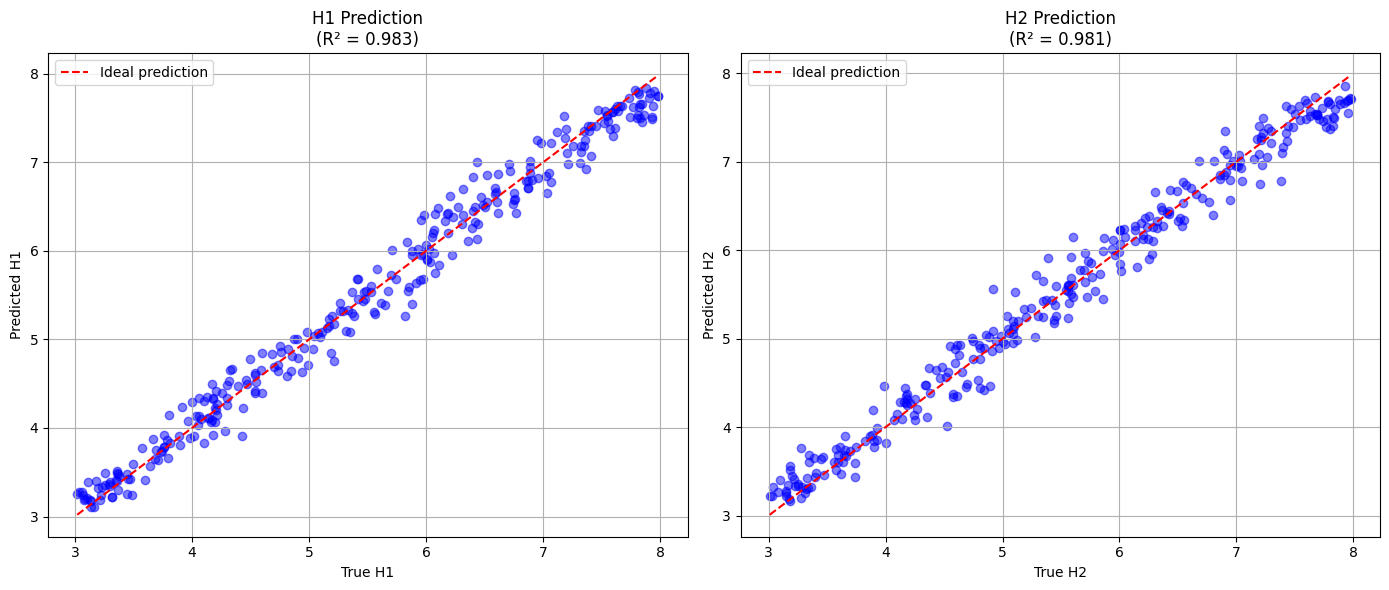

In [26]:
# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1507
  Median Absolute Error: 0.1164
  Max Error: 0.5619
  Standard Deviation: 0.1192

H2:
  Mean Absolute Error: 0.1583
  Median Absolute Error: 0.1292
  Max Error: 0.6439
  Standard Deviation: 0.1234


/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


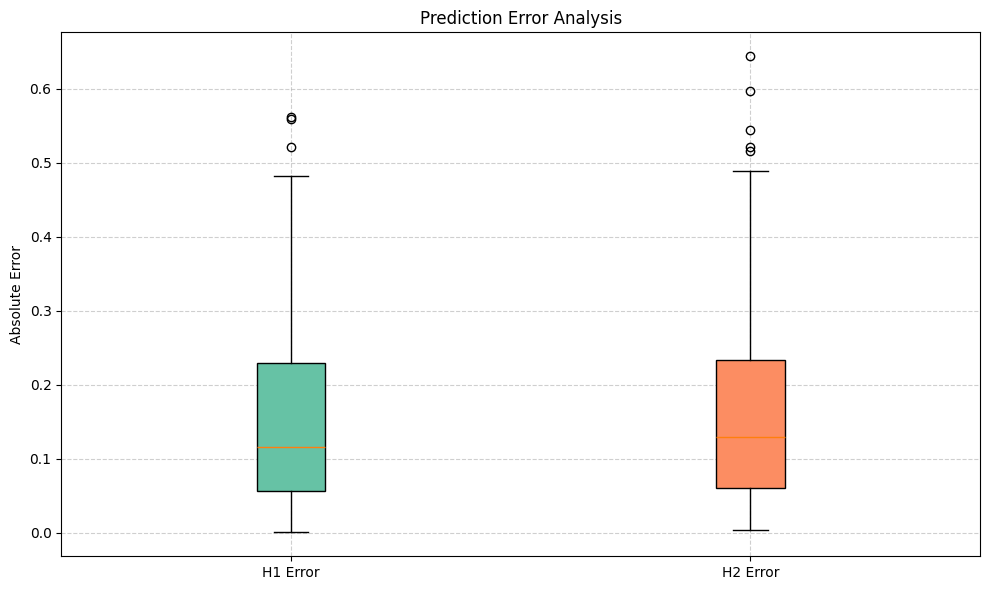

In [27]:
# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

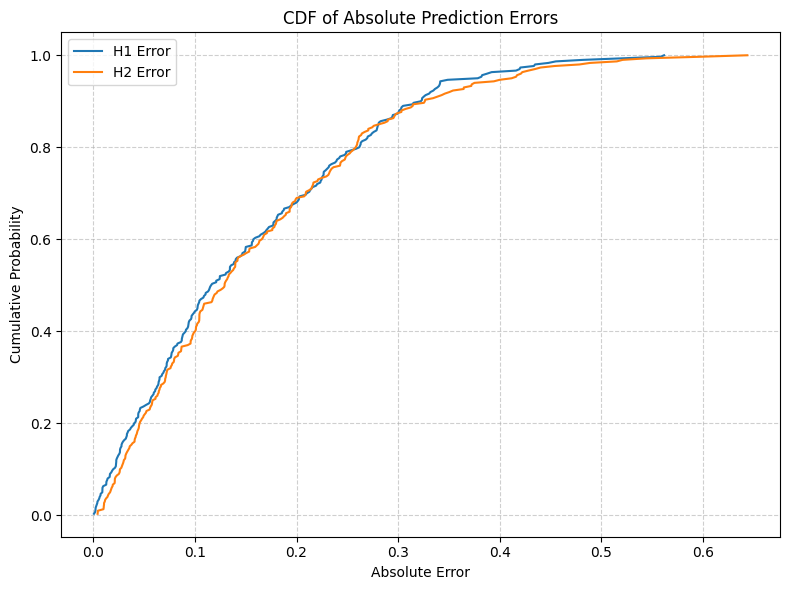

In [28]:
fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

| **Absolute Error (x)** | **Cumulative Probability (y)** | **Interpretation**                   |
| ---------------------- | ------------------------------ | ------------------------------------ |
| 0.05                   | 0.40                           | 40% of predictions have error ≤ 0.05 |
| 0.10                   | 0.75                           | 75% of predictions have error ≤ 0.10 |
| 0.20                   | 0.90                           | 90% of predictions have error ≤ 0.20 |
| 0.40                   | 0.98                           | 98% of predictions have error ≤ 0.40 |
| 1.00                   | 1.00                           | 100% of predictions have error ≤ 1.0 |


In [29]:
X.shape

(1000, 18)

##LINEAR REGRESSION

H1 → R²: 0.97857, RMSE: 0.21816, MAE: 0.17489, MAPE: 3.56%
H2 → R²: 0.97770, RMSE: 0.21850, MAE: 0.17698, MAPE: 3.42%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  6.107355   4.788697  4.762624
1     3.457886  3.161057   3.927600  3.991590
2     3.446417  2.909069   5.697599  6.074285
3     3.290314  3.151845   7.668087  7.317462
4     7.843580  7.681337   5.183856  5.595308
..         ...       ...        ...       ...
295   4.857700  4.919978   7.879422  7.787134
296   4.142785  4.176615   5.089049  5.164575
297   4.210995  4.145484   4.612836  4.875551
298   7.412953  7.453670   6.282756  6.179211
299   7.386855  7.104034   4.482807  4.804114

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1749
  Median Absolute Error: 0.1490
  Max Error: 0.6739
  Standard Deviation: 0.1304

H2:
  Mean Absolute Error: 0.1770
  Median Absolute Error: 0.1495
  Max Error: 0.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


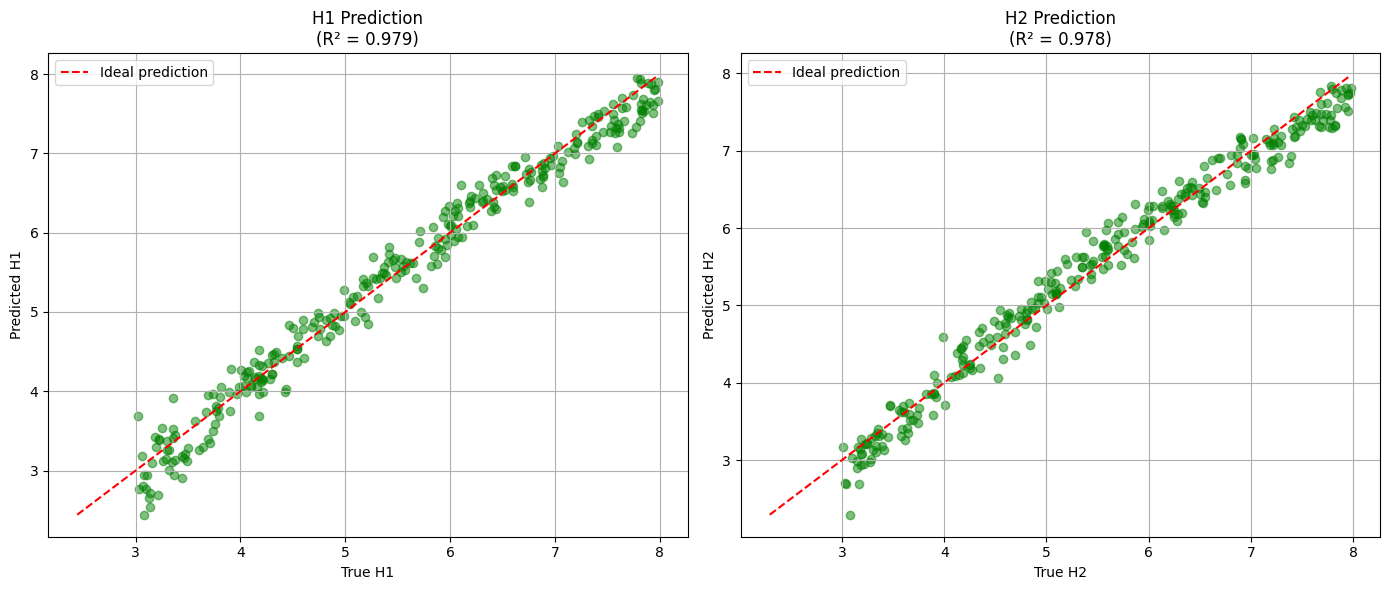

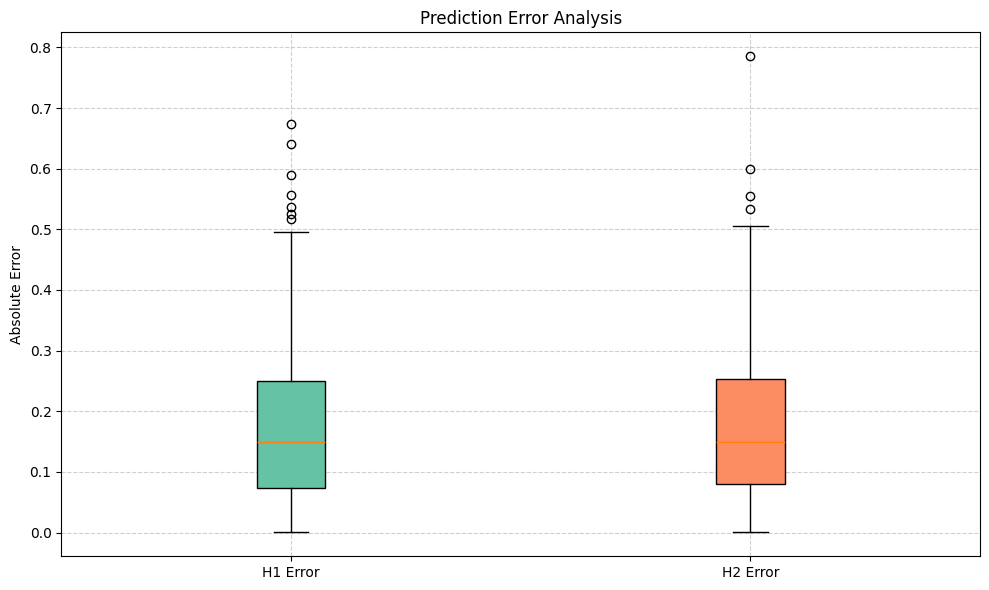

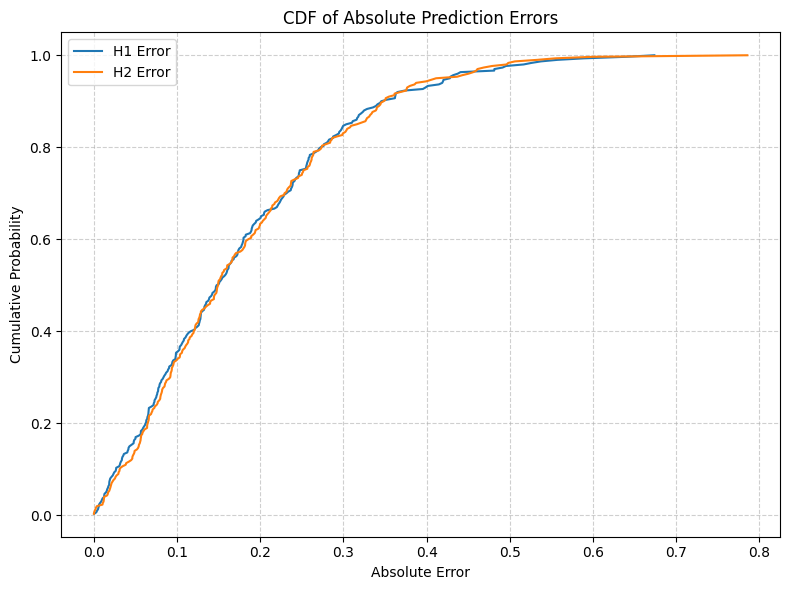

In [30]:
from sklearn.linear_model import LinearRegression



# Train Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred = model.predict(X_test_scaled)
Y_true = Y_test.copy()


results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='green')

# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])


In [31]:
X.shape

(1000, 18)

##XGBOOST

In [32]:
import xgboost as xgb



In [33]:


# === Separate features and targets ===
X = df_filtered.drop(columns=['H1', 'H2']).values
Y = df_filtered[['H1', 'H2']].values

# === Train/val/test split ===
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# === Min-Max Scaling ===
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train)
Y_val_scaled   = Y_scaler.transform(Y_val)
Y_test_scaled  = Y_scaler.transform(Y_test)

# === Train a separate XGBoost model for H1 and H2 ===
models = []
for i in range(Y.shape[1]):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train_scaled, Y_train_scaled[:, i])
    models.append(model)

# === Predict and inverse transform ===
Y_pred_scaled = np.column_stack([model.predict(X_test_scaled) for model in models])
Y_pred = Y_scaler.inverse_transform(Y_pred_scaled)
Y_true = Y_scaler.inverse_transform(Y_test_scaled)





H1 → R²: 0.97561, RMSE: 0.22851, MAE: 0.17525, MAPE: 3.52%
H2 → R²: 0.97957, RMSE: 0.20069, MAE: 0.16164, MAPE: 3.06%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     7.943594  7.844172   5.603308  5.868980
1     5.420345  5.447331   3.824164  3.766197
2     5.314974  5.227497   7.401010  7.082437
3     7.743740  7.739036   7.047137  6.753752
4     3.182145  3.625769   5.666627  5.648547
..         ...       ...        ...       ...
145   3.467523  3.526161   3.328638  3.509401
146   3.314988  3.129805   5.457638  5.581270
147   7.881852  7.965575   4.122413  4.370169
148   6.403740  6.209394   5.018105  5.011784
149   6.592408  6.378272   3.592435  3.691339

[150 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1753
  Median Absolute Error: 0.1395
  Max Error: 0.6152
  Standard Deviation: 0.1466

H2:
  Mean Absolute Error: 0.1616
  Median Absolute Error: 0.1427
  Max Error: 0.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


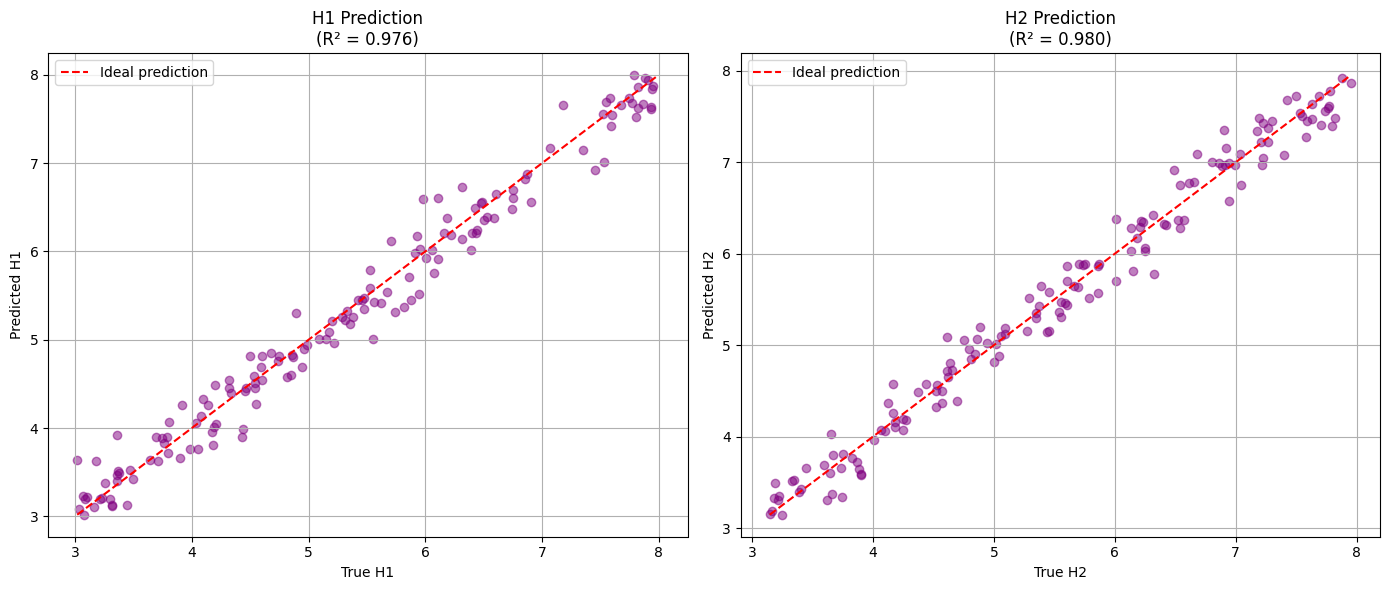

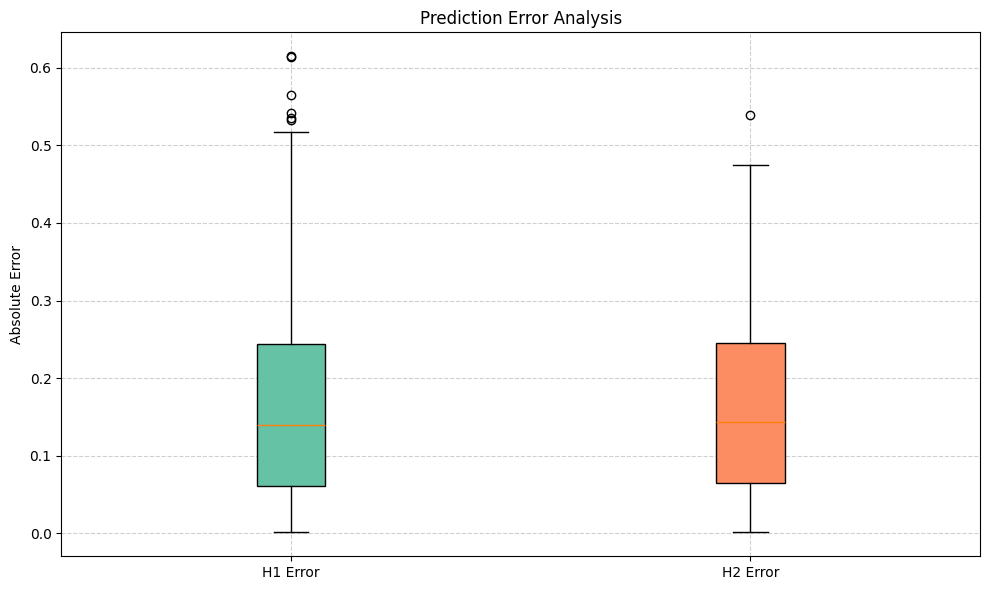

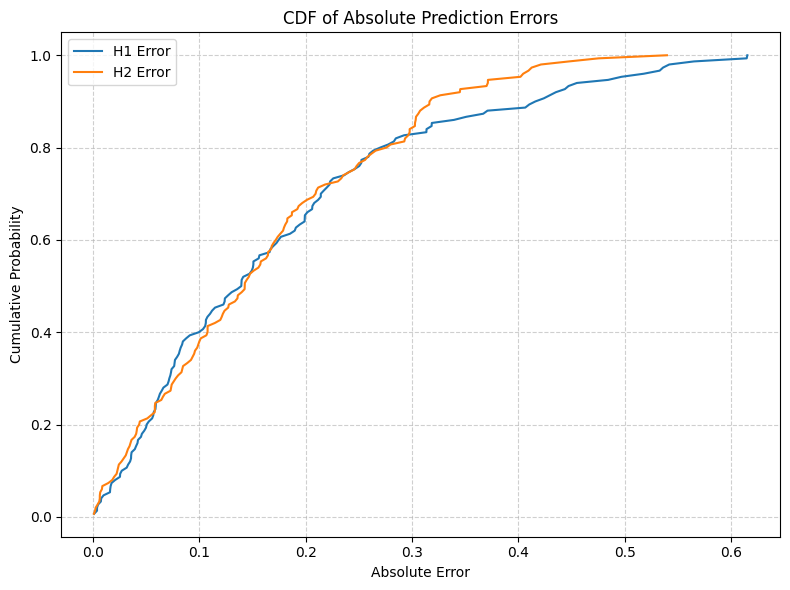

In [34]:
results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='purple')

# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

##SVR

H1 → R²: 0.96895, RMSE: 0.26258, MAE: 0.21222, MAPE: 4.29%
H2 → R²: 0.97115, RMSE: 0.24855, MAE: 0.19567, MAPE: 3.89%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  6.170299   4.788697  4.527155
1     3.457886  3.745350   3.927600  3.960515
2     3.446417  3.497201   5.697599  6.148116
3     3.290314  3.679682   7.668087  7.407492
4     7.843580  7.649067   5.183856  5.496561
..         ...       ...        ...       ...
295   4.857700  4.930414   7.879422  7.505864
296   4.142785  4.170627   5.089049  4.786082
297   4.210995  4.315113   4.612836  4.733314
298   7.412953  7.337233   6.282756  6.137021
299   7.386855  7.311866   4.482807  4.551494

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.2122
  Median Absolute Error: 0.1909
  Max Error: 0.8786
  Standard Deviation: 0.1546

H2:
  Mean Absolute Error: 0.1957
  Median Absolute Error: 0.1531
  Max Error: 0.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


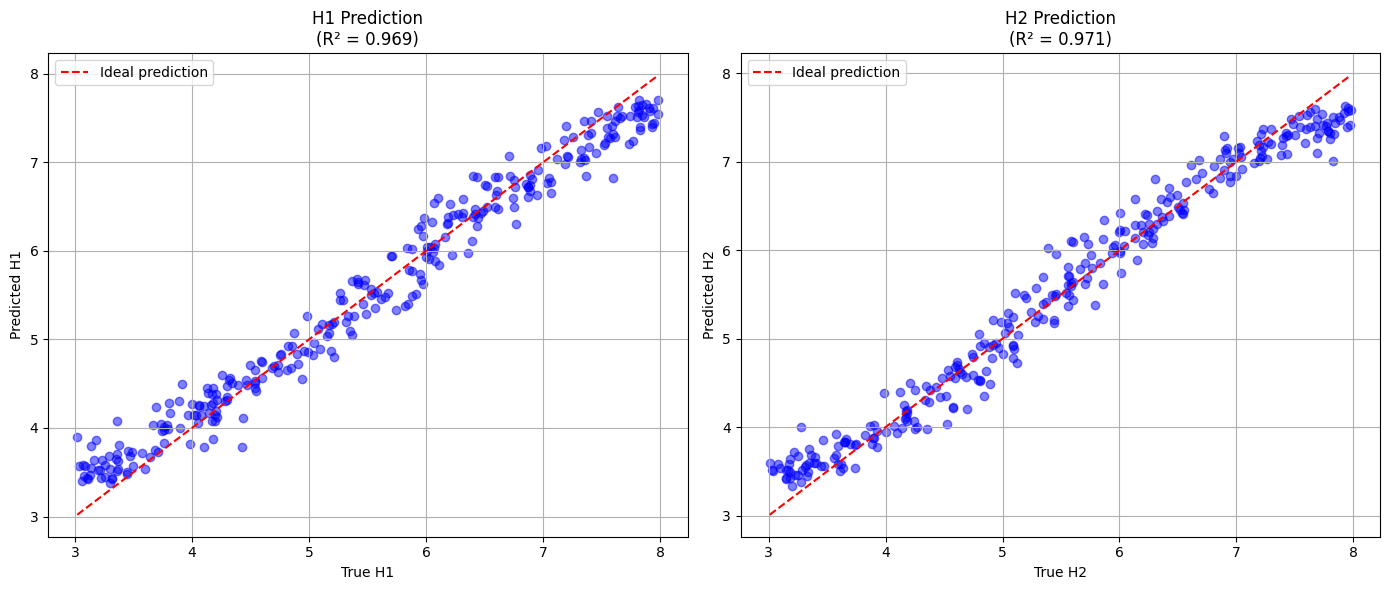

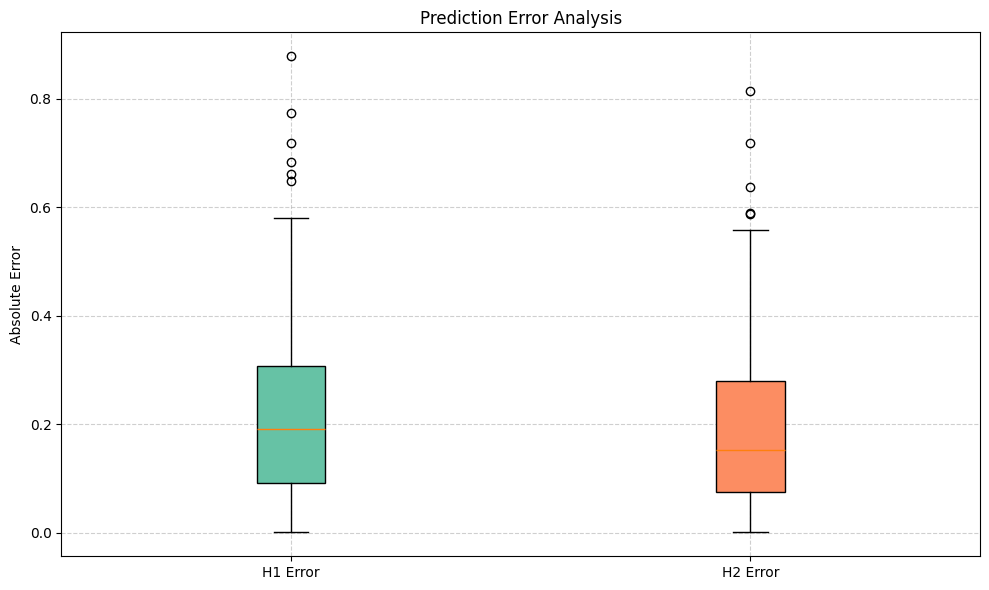

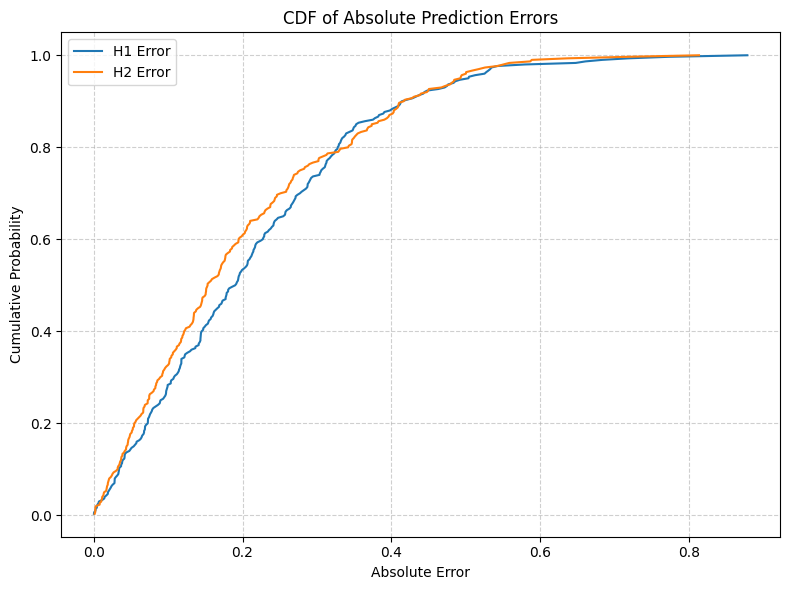

In [35]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler
import numpy as np # Import numpy

# Assuming X and Y are loaded from the .mat file as done earlier in the notebook

# === Train/test split ===
# This split determines the samples for the SVR model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale Y data as well if needed for the model
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test) # Use the Y_test from THIS split

# -------------------------------
# Train Multi-Output SVR
# -------------------------------
base_svr = SVR(kernel='rbf', C=100, epsilon=0.1)
model_svr = MultiOutputRegressor(base_svr)

model_svr.fit(X_train_scaled, Y_train_scaled) # Train on scaled Y

# -------------------------------
# Predict and Inverse-Transform y
# -------------------------------
y_pred_scaled = model_svr.predict(X_test_scaled)
Y_pred = scaler.inverse_transform(y_pred_scaled)

# Use the correct Y_test from THIS split as the true values for evaluation
Y_true = Y_test # Now Y_true and Y_pred will have the same number of samples (219)

# -------------------------------
# Evaluate and Plot (assuming helper functions are defined elsewhere)
# -------------------------------
results = evaluate_predictions(Y_true, Y_pred) # Y_true and Y_pred have 219 samples

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred) # Use Y_true for consistency
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_true, Y_pred, # Use Y_true
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

# Basic boxplot
fig, stats = plot_error_analysis(Y_true, Y_pred) # Use Y_true

# Ensure Y_test is also a numpy array for plot_error_cdfs
fig = plot_error_cdfs(Y_true, Y_pred, target_names=['H1', 'H2']) # Use Y_true

##MLP with 2 layers

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




In [37]:
X.shape

(1000, 18)

In [38]:
print("X dimensions: ",X.shape)
print("Y dimensions: ",Y.shape)

X dimensions:  (1000, 18)
Y dimensions:  (1000, 2)


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

class InertiaRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = InertiaRegressionDataset(X_train_scaled, Y_train_scaled)
test_dataset = InertiaRegressionDataset(X_test_scaled, Y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [40]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64
            ),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 outputs: H1 and H2
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=18)


In [41]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.MSELoss()

# # Hyperparameters
# learning_rate = 1e-3
# weight_decay = 1e-5
# early_stop_patience = 5      # number of checks without improvement
# check_every = 30             # check every 30 batches
# best_val_loss = float('inf')
# no_improve_count = 0
# step = 0

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
#     weight_decay=weight_decay
# )

# for epoch in range(2000):
#     model.train()
#     running_loss = 0
#     for batch_x, batch_y in train_loader:
#         step += 1
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         output = model(batch_x)
#         loss = criterion(output, batch_y)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         # ✅ Check validation loss every `check_every` steps
#         if step % check_every == 0:
#             model.eval()
#             val_losses = []
#             with torch.no_grad():
#                 for val_x, val_y in test_loader:  # Use test_loader as validation
#                     val_x, val_y = val_x.to(device), val_y.to(device)
#                     val_out = model(val_x)
#                     val_loss = criterion(val_out, val_y).item()
#                     val_losses.append(val_loss)

#             avg_val_loss = sum(val_losses) / len(val_losses)
#             print(f"Step {step}, Validation Loss: {avg_val_loss:.4f}")

#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 no_improve_count = 0
#             else:
#                 no_improve_count += 1
#                 if no_improve_count >= early_stop_patience:
#                     print(f"Early stopping triggered at step {step}.")
#                     break
#             model.train()

#     print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")

#     if no_improve_count >= early_stop_patience:
#         print(f"Early stopping ended training at epoch {epoch+1}.")
#         break


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




for epoch in range(1500):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.2174
Epoch 2, Loss: 0.0419
Epoch 3, Loss: 0.0155
Epoch 4, Loss: 0.0051
Epoch 5, Loss: 0.0026
Epoch 6, Loss: 0.0023
Epoch 7, Loss: 0.0021
Epoch 8, Loss: 0.0019
Epoch 9, Loss: 0.0018
Epoch 10, Loss: 0.0017
Epoch 11, Loss: 0.0016
Epoch 12, Loss: 0.0015
Epoch 13, Loss: 0.0015
Epoch 14, Loss: 0.0014
Epoch 15, Loss: 0.0014
Epoch 16, Loss: 0.0013
Epoch 17, Loss: 0.0013
Epoch 18, Loss: 0.0013
Epoch 19, Loss: 0.0012
Epoch 20, Loss: 0.0012
Epoch 21, Loss: 0.0012
Epoch 22, Loss: 0.0012
Epoch 23, Loss: 0.0012
Epoch 24, Loss: 0.0012
Epoch 25, Loss: 0.0011
Epoch 26, Loss: 0.0011
Epoch 27, Loss: 0.0011
Epoch 28, Loss: 0.0011
Epoch 29, Loss: 0.0011
Epoch 30, Loss: 0.0011
Epoch 31, Loss: 0.0011
Epoch 32, Loss: 0.0011
Epoch 33, Loss: 0.0011
Epoch 34, Loss: 0.0011
Epoch 35, Loss: 0.0011
Epoch 36, Loss: 0.0010
Epoch 37, Loss: 0.0011
Epoch 38, Loss: 0.0011
Epoch 39, Loss: 0.0011
Epoch 40, Loss: 0.0012
Epoch 41, Loss: 0.0010
Epoch 42, Loss: 0.0010
Epoch 43, Loss: 0.0010
Epoch 44, Loss: 0.00

In [43]:
from sklearn.metrics import mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

model.eval()
y_pred_all, y_true_all = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).cpu().numpy()
        y_pred_all.append(output)
        y_true_all.append(batch_y.numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)


# After collecting predictions and targets
y_pred_all = scaler.inverse_transform(y_pred_all)
y_true_all = scaler.inverse_transform(y_true_all)


# # Metrics
# mse = np.mean((y_true_all - y_pred_all)**2)
# mae = mean_absolute_error(y_true_all, y_pred_all)
# mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
# r2 = r2_score(y_true_all, y_pred_all)

# print(f"Test MSE:  {mse:.4f}")
# print(f"Test MAE:  {mae:.4f}")
# print(f"Test MAPE: {mape:.2f}%")
# print(f"Test R^2:  {r2:.4f}")


In [44]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error


for i, name in enumerate(['H1', 'H2']):
    true = y_true_all[:, i]
    pred = y_pred_all[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")

H1 → R²: 0.98511, RMSE: 0.18183,MAE: 0.14184, MAPE: 2.68%
H2 → R²: 0.99097, RMSE: 0.13905,MAE: 0.11074, MAPE: 2.11%


H1 → R²: 0.98511, RMSE: 0.18183, MAE: 0.14184, MAPE: 2.68%
H2 → R²: 0.99097, RMSE: 0.13905, MAE: 0.11074, MAPE: 2.11%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  6.100262   4.788697  4.748980
1     3.457886  3.361782   3.927600  3.936451
2     3.446417  3.300279   5.697599  5.706672
3     3.290314  3.153765   7.668087  7.568427
4     7.843579  7.674247   5.183856  5.445211
..         ...       ...        ...       ...
295   4.857700  4.695859   7.879422  8.007108
296   4.142785  3.989892   5.089049  5.090996
297   4.210995  4.386349   4.612836  4.505603
298   7.412953  7.522090   6.282757  6.127906
299   7.386855  7.159657   4.482807  4.643967

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1418
  Median Absolute Error: 0.1207
  Max Error: 0.6054
  Standard Deviation: 0.1138

H2:
  Mean Absolute Error: 0.1107
  Median Absolute Error: 0.0911
  Max Error: 0.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


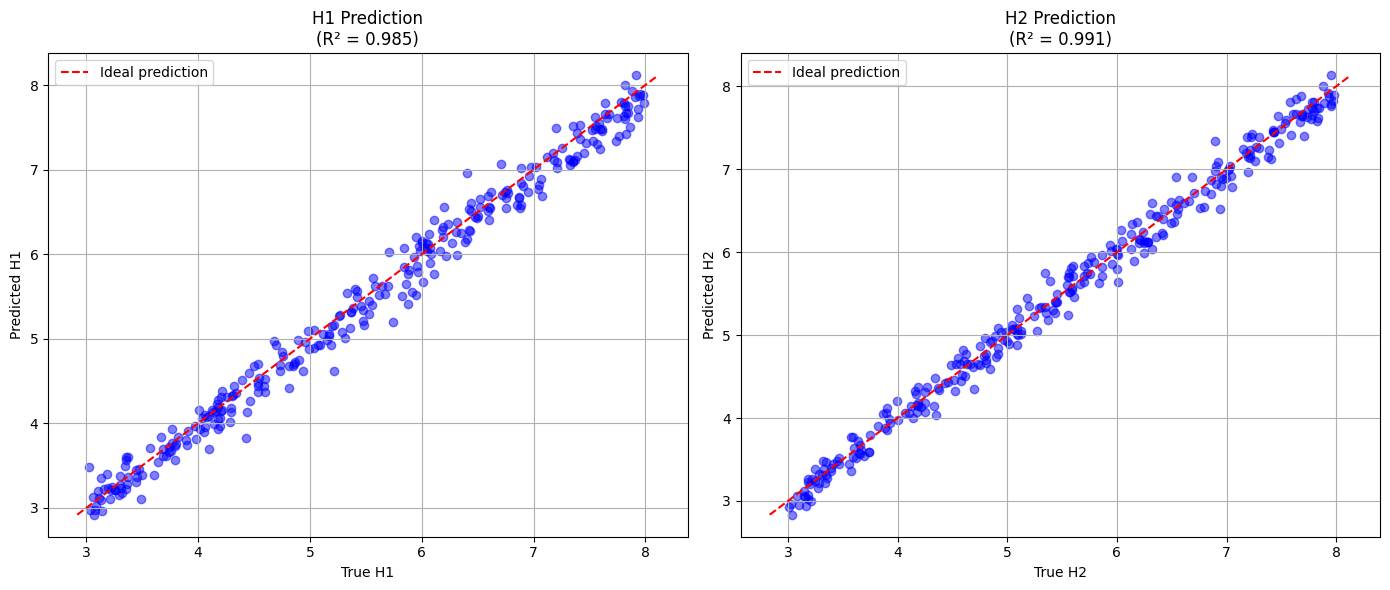

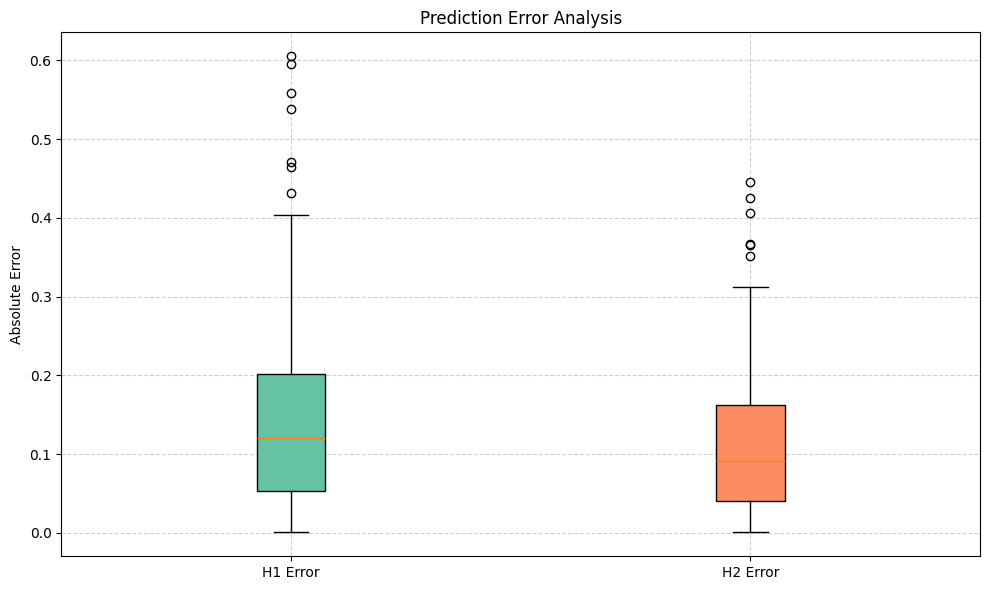

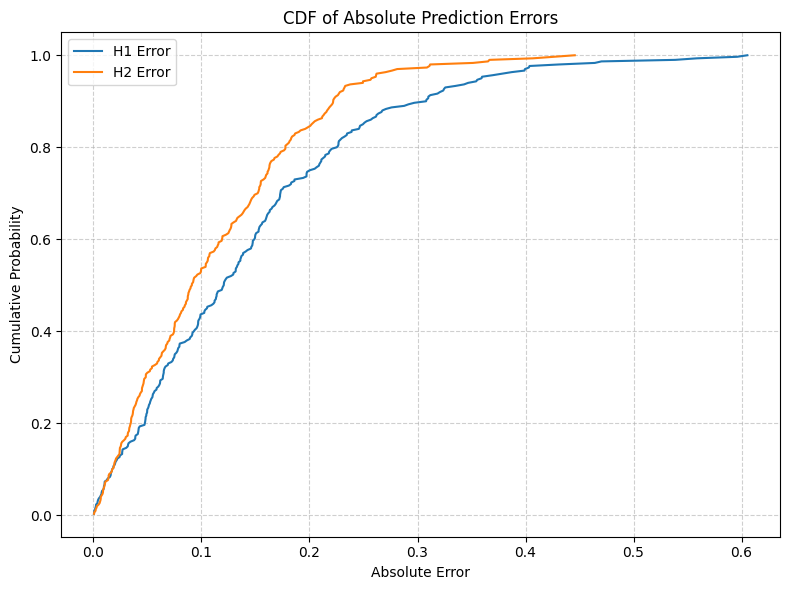

In [45]:
# Predict and Inverse-Transform y
# -------------------------------
Y_pred = y_pred_all.copy()

# Use the correct Y_test from THIS split as the true values for evaluation
Y_true = y_true_all.copy() # Now Y_true and Y_pred will have the same number of samples (219)

# -------------------------------
# Evaluate and Plot (assuming helper functions are defined elsewhere)
# -------------------------------
results = evaluate_predictions(Y_true,Y_pred) # Y_true and Y_pred have 219 samples

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred) # Use Y_true for consistency
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_true, Y_pred, # Use Y_true
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

# Basic boxplot
fig, stats = plot_error_analysis(Y_pred, Y_true) # Use Y_true

# Ensure Y_test is also a numpy array for plot_error_cdfs
fig = plot_error_cdfs(Y_true, Y_pred, target_names=['H1', 'H2']) # Use Y_true




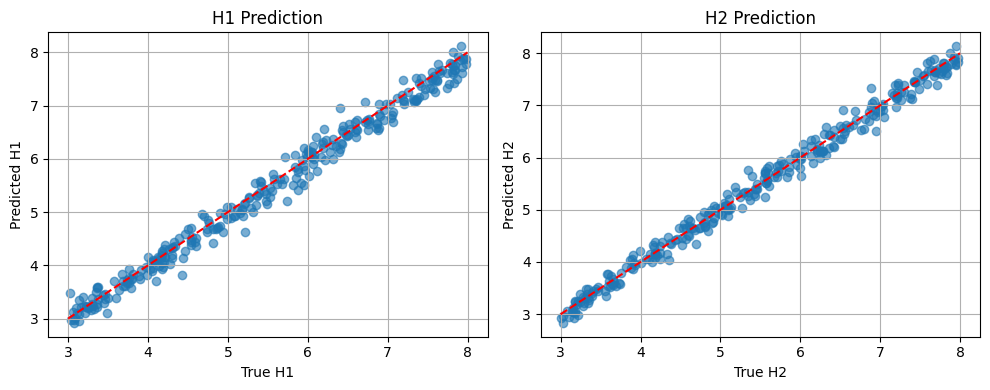

In [46]:
# H1 Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_true_all[:, 0],y_pred_all[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(y_true_all[:, 1],y_pred_all[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()